https://github.com/thepetk/docling-example

In [1]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 647.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.9 MB/s eta 0:00:00


In [3]:
!pip install docling-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.3/142.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 5.4 MB/s eta 0:00:00


In [2]:
# Prerequisites:
# pip install onnxruntime
# pip install onnxruntime-gpu
from transformers import AutoConfig, AutoProcessor
from transformers.image_utils import load_image
import onnxruntime
import numpy as np
import os
from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument

os.environ["OMP_NUM_THREADS"] = "1"
# cuda
os.environ["ORT_CUDA_USE_MAX_WORKSPACE"] = "1"

# 1. Load models
## Load config and processor
model_id = "ds4sd/SmolDocling-256M-preview"
config = AutoConfig.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

## Load sessions
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/embed_tokens.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/decoder_model_merged.onnx
# cpu
vision_session = onnxruntime.InferenceSession("vision_encoder.onnx")
embed_session = onnxruntime.InferenceSession("embed_tokens.onnx")
decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx")

# cuda
#vision_session = onnxruntime.InferenceSession("vision_encoder.onnx", providers=["CUDAExecutionProvider"])
#embed_session = onnxruntime.InferenceSession("embed_tokens.onnx", providers=["CUDAExecutionProvider"])
#decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx", providers=["CUDAExecutionProvider"])

## Set config values
num_key_value_heads = config.text_config.num_key_value_heads
head_dim = config.text_config.head_dim
num_hidden_layers = config.text_config.num_hidden_layers
eos_token_id = config.text_config.eos_token_id
image_token_id = config.image_token_id
end_of_utterance_id = processor.tokenizer.convert_tokens_to_ids("<end_of_utterance>")

# 2. Prepare inputs
## Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."}
        ]
    },
]

## Load image and apply processor
image = load_image("https://ibm.biz/docling-page-with-table")
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="np")

## Prepare decoder inputs
batch_size = inputs['input_ids'].shape[0]
past_key_values = {
    f'past_key_values.{layer}.{kv}': np.zeros([batch_size, num_key_value_heads, 0, head_dim], dtype=np.float32)
    for layer in range(num_hidden_layers)
    for kv in ('key', 'value')
}
image_features = None
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
position_ids = np.cumsum(inputs['attention_mask'], axis=-1)


# 3. Generation loop
max_new_tokens = 8192
generated_tokens = np.array([[]], dtype=np.int64)
for i in range(max_new_tokens):
  inputs_embeds = embed_session.run(None, {'input_ids': input_ids})[0]

  if image_features is None:
    ## Only compute vision features if not already computed
    image_features = vision_session.run(
        ['image_features'],  # List of output names or indices
        {
            'pixel_values': inputs['pixel_values'],
            'pixel_attention_mask': inputs['pixel_attention_mask'].astype(np.bool_)
        }
    )[0]

    ## Merge text and vision embeddings
    inputs_embeds[inputs['input_ids'] == image_token_id] = image_features.reshape(-1, image_features.shape[-1])

  logits, *present_key_values = decoder_session.run(None, dict(
      inputs_embeds=inputs_embeds,
      attention_mask=attention_mask,
      position_ids=position_ids,
      **past_key_values,
  ))

  ## Update values for next generation loop
  input_ids = logits[:, -1].argmax(-1, keepdims=True)
  attention_mask = np.ones_like(input_ids)
  position_ids = position_ids[:, -1:] + 1
  for j, key in enumerate(past_key_values):
    past_key_values[key] = present_key_values[j]

  generated_tokens = np.concatenate([generated_tokens, input_ids], axis=-1)
  if (input_ids == eos_token_id).all() or (input_ids == end_of_utterance_id).all():
    break  # Stop predicting

doctags = processor.batch_decode(
    generated_tokens,
    skip_special_tokens=False,
)[0].lstrip()

print(doctags)

doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
print(doctags)
# create a docling document
doc = DoclingDocument(name="Document")
doc.load_from_doctags(doctags_doc)

print(doc.export_to_markdown())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--2025-05-11 02:32:41--  https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
Resolving huggingface.co (huggingface.co)... 18.238.136.32, 18.238.136.71, 18.238.136.112, ...
Connecting to huggingface.co (huggingface.co)|18.238.136.32|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/b8/6e/b86e88e6db456aab3c09c424eee0c6e3c444c4122486d3f9ec088b13c389b0f9/9c97aafac0543632c778938e2870afb73a81c7cc3a3e01e84b43a096bd668820?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27vision_encoder.onnx%3B+filename%3D%22vision_encoder.onnx%22%3B&Expires=1746934361&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjkzNDM2MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2I4LzZlL2I4NmU4OGU2ZGI0NTZhYWIzYzA5YzQyNGVlZTBjNmUzYzQ0NGM0MTIyNDg2ZDNmOWVjMDg4YjEzYzM4OWIwZjkvOWM5N2FhZmFjMDU0MzYzMmM3Nzg5MzhlMjg3MGFmYjczYTgxYzdjYzNhM2UwMWU4NGI0M2EwOTZiZ

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<doctag><page_header><loc_127><loc_27><loc_420><loc_34>Optimized Table Tokenization for Table Structure Recognition</page_header>
<page_header><loc_451><loc_27><loc_457><loc_34>9</page_header>
<text><loc_57><loc_46><loc_457><loc_71>order to compute the TED score. Inference timing results for all experiments were obtained from the same machine on a single core with AMD EPYC 7763 CPU @2.45 GHz.</text>
<section_header_level_1><loc_57><loc_84><loc_271><loc_92>5.1 Hyper Parameter Optimization</section_header_level_1>
<text><loc_57><loc_97><loc_457><loc_149>We have chosen the PubTabNet data set to perform HPO, since it includes a highly diverse set of tables. Also we report TED scores separately for simple and complex tables (tables with cell spans). Results are presented in Table. 1. It is evident that with OTSL, our model achieves the same TED score and slightly better mAP scores in comparison to HTML. However OTSL yields a 2x speed up in the inference runtime over HTML.</text>
<otsl><loc_

In [3]:
# Prerequisites:
# pip install onnxruntime
# pip install onnxruntime-gpu
from transformers import AutoConfig, AutoProcessor
from transformers.image_utils import load_image
import onnxruntime
import numpy as np
import os
from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument

os.environ["OMP_NUM_THREADS"] = "1"
# cuda
os.environ["ORT_CUDA_USE_MAX_WORKSPACE"] = "1"

# 1. Load models
## Load config and processor
model_id = "ds4sd/SmolDocling-256M-preview"
config = AutoConfig.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

## Load sessions
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/embed_tokens.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/decoder_model_merged.onnx
# cpu
vision_session = onnxruntime.InferenceSession("vision_encoder.onnx")
embed_session = onnxruntime.InferenceSession("embed_tokens.onnx")
decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx")

# cuda
#vision_session = onnxruntime.InferenceSession("vision_encoder.onnx", providers=["CUDAExecutionProvider"])
#embed_session = onnxruntime.InferenceSession("embed_tokens.onnx", providers=["CUDAExecutionProvider"])
#decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx", providers=["CUDAExecutionProvider"])

## Set config values
num_key_value_heads = config.text_config.num_key_value_heads
head_dim = config.text_config.head_dim
num_hidden_layers = config.text_config.num_hidden_layers
eos_token_id = config.text_config.eos_token_id
image_token_id = config.image_token_id
end_of_utterance_id = processor.tokenizer.convert_tokens_to_ids("<end_of_utterance>")

# 2. Prepare inputs
## Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."}
        ]
    },
]

## Load image and apply processor
image = load_image("https://ibm.biz/docling-page-with-table")
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="np", truncation=True, max_length=512)

## Prepare decoder inputs
batch_size = inputs['input_ids'].shape[0]
past_key_values = {
    f'past_key_values.{layer}.{kv}': np.zeros([batch_size, num_key_value_heads, 0, head_dim], dtype=np.float32)
    for layer in range(num_hidden_layers)
    for kv in ('key', 'value')
}
image_features = None
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
position_ids = np.cumsum(inputs['attention_mask'], axis=-1)


# 3. Generation loop
max_new_tokens = 8192
generated_tokens = np.array([[]], dtype=np.int64)
for i in range(max_new_tokens):
  inputs_embeds = embed_session.run(None, {'input_ids': input_ids})[0]

  if image_features is None:
    ## Only compute vision features if not already computed
    image_features = vision_session.run(
        ['image_features'],  # List of output names or indices
        {
            'pixel_values': inputs['pixel_values'],
            'pixel_attention_mask': inputs['pixel_attention_mask'].astype(np.bool_)
        }
    )[0]

    ## Merge text and vision embeddings
    inputs_embeds[inputs['input_ids'] == image_token_id] = image_features.reshape(-1, image_features.shape[-1])

  logits, *present_key_values = decoder_session.run(None, dict(
      inputs_embeds=inputs_embeds,
      attention_mask=attention_mask,
      position_ids=position_ids,
      **past_key_values,
  ))

  ## Update values for next generation loop
  input_ids = logits[:, -1].argmax(-1, keepdims=True)
  attention_mask = np.ones_like(input_ids)
  position_ids = position_ids[:, -1:] + 1
  for j, key in enumerate(past_key_values):
    past_key_values[key] = present_key_values[j]

  generated_tokens = np.concatenate([generated_tokens, input_ids], axis=-1)
  if (input_ids == eos_token_id).all() or (input_ids == end_of_utterance_id).all():
    break  # Stop predicting

doctags = processor.batch_decode(
    generated_tokens,
    skip_special_tokens=False,
)[0].lstrip()

print(doctags)

doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
print(doctags)
# create a docling document
doc = DoclingDocument(name="Document")
doc.load_from_doctags(doctags_doc)

print(doc.export_to_markdown())


--2025-05-11 02:42:12--  https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
Resolving huggingface.co (huggingface.co)... 18.238.136.112, 18.238.136.71, 18.238.136.129, ...
Connecting to huggingface.co (huggingface.co)|18.238.136.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/b8/6e/b86e88e6db456aab3c09c424eee0c6e3c444c4122486d3f9ec088b13c389b0f9/9c97aafac0543632c778938e2870afb73a81c7cc3a3e01e84b43a096bd668820?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27vision_encoder.onnx%3B+filename%3D%22vision_encoder.onnx%22%3B&Expires=1746934932&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjkzNDkzMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2I4LzZlL2I4NmU4OGU2ZGI0NTZhYWIzYzA5YzQyNGVlZTBjNmUzYzQ0NGM0MTIyNDg2ZDNmOWVjMDg4YjEzYzM4OWIwZjkvOWM5N2FhZmFjMDU0MzYzMmM3Nzg5MzhlMjg3MGFmYjczYTgxYzdjYzNhM2UwMWU4NGI0M2EwOTZ

ValueError: shape mismatch: value array of shape (832,576) could not be broadcast to indexing result of shape (491,576)

In [ ]:
inputs = processor(text=prompt, images=[image], return_tensors="np", truncation=True, max_length=512)  # or your desired max_length

In [2]:
# Prerequisites:
# pip install onnxruntime
# pip install onnxruntime-gpu
from transformers import AutoConfig, AutoProcessor
from transformers.image_utils import load_image
import onnxruntime
import numpy as np
import os
from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument

os.environ["OMP_NUM_THREADS"] = "1"
# cuda
os.environ["ORT_CUDA_USE_MAX_WORKSPACE"] = "1"

# 1. Load models
## Load config and processor
model_id = "ds4sd/SmolDocling-256M-preview"
config = AutoConfig.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

## Load sessions
# cpu
vision_session = onnxruntime.InferenceSession("vision_encoder.onnx")
embed_session = onnxruntime.InferenceSession("embed_tokens.onnx")
decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx")

## Set config values
num_key_value_heads = config.text_config.num_key_value_heads
head_dim = config.text_config.head_dim
num_hidden_layers = config.text_config.num_hidden_layers
eos_token_id = config.text_config.eos_token_id
image_token_id = config.image_token_id
end_of_utterance_id = processor.tokenizer.convert_tokens_to_ids("<end_of_utterance>")

# 2. Prepare inputs
## Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."}
        ]
    },
]

## Load image and apply processor
image = load_image("https://ibm.biz/docling-page-with-table")
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
# The issue was likely caused by the input sequence being too long.
# Applying truncation before tokenization ensures that the sequence length does not exceed the model's maximum context length.
inputs = processor(text=prompt, images=[image], return_tensors="np", truncation=True, max_length=512)  # or your desired max_length

## Prepare decoder inputs
batch_size = inputs['input_ids'].shape[0]
past_key_values = {
    f'past_key_values.{layer}.{kv}': np.zeros([batch_size, num_key_value_heads, 0, head_dim], dtype=np.float32)
    for layer in range(num_hidden_layers)
    for kv in ('key', 'value')
}
image_features = None
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
position_ids = np.cumsum(inputs['attention_mask'], axis=-1)


# 3. Generation loop
max_new_tokens = 8192
generated_tokens = np.array([[]], dtype=np.int64)
for i in range(max_new_tokens):
  inputs_embeds = embed_session.run(None, {'input_ids': input_ids})[0]

  if image_features is None:
    ## Only compute vision features if not already computed
    image_features = vision_session.run(
        ['image_features'],  # List of output names or indices
        {
            'pixel_values': inputs['pixel_values'],
            'pixel_attention_mask': inputs['pixel_attention_mask'].astype(np.bool_)
        }
    )[0]

    ## Merge text and vision embeddings
    # Reshape image_features to match the number of image tokens.
    image_features_reshaped = image_features.reshape(inputs['input_ids'][inputs['input_ids'] == image_token_id].shape[0], image_features.shape[-1])
    inputs_embeds[inputs['input_ids'] == image_token_id] = image_features_reshaped

  logits, *present_key_values = decoder_session.run(None, dict(
      inputs_embeds=inputs_embeds,
      attention_mask=attention_mask,
      position_ids=position_ids,
      **past_key_values,
  ))

  ## Update values for next generation loop
  input_ids = logits[:, -1].argmax(-1, keepdims=True)
  attention_mask = np.ones_like(input_ids)
  position_ids = position_ids[:, -1:] + 1
  for j, key in enumerate(past_key_values):
    past_key_values[key] = present_key_values[j]

  generated_tokens = np.concatenate([generated_tokens, input_ids], axis=-1)
  if (input_ids == eos_token_id).all() or (input_ids == end_of_utterance_id).all():
    break  # Stop predicting

doctags = processor.batch_decode(
    generated_tokens,
    skip_special_tokens=False,
)[0].lstrip()

print(doctags)

doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
print(doctags)
# create a docling document
doc = DoclingDocument(name="Document")
doc.load_from_doctags(doctags_doc)

print(doc.export_to_markdown())

ValueError: cannot reshape array of size 479232 into shape (491,576)

In [1]:
# Prerequisites:
# pip install onnxruntime
# pip install onnxruntime-gpu
from transformers import AutoConfig, AutoProcessor
from transformers.image_utils import load_image
import onnxruntime
import numpy as np
import os
from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument

os.environ["OMP_NUM_THREADS"] = "1"
# cuda
os.environ["ORT_CUDA_USE_MAX_WORKSPACE"] = "1"

# 1. Load models
## Load config and processor
model_id = "ds4sd/SmolDocling-256M-preview"
config = AutoConfig.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

## Load sessions
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/embed_tokens.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/decoder_model_merged.onnx
# cpu
vision_session = onnxruntime.InferenceSession("vision_encoder.onnx")
embed_session = onnxruntime.InferenceSession("embed_tokens.onnx")
decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx")

# cuda
#vision_session = onnxruntime.InferenceSession("vision_encoder.onnx", providers=["CUDAExecutionProvider"])
#embed_session = onnxruntime.InferenceSession("embed_tokens.onnx", providers=["CUDAExecutionProvider"])
#decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx", providers=["CUDAExecutionProvider"])

## Set config values
num_key_value_heads = config.text_config.num_key_value_heads
head_dim = config.text_config.head_dim
num_hidden_layers = config.text_config.num_hidden_layers
eos_token_id = config.text_config.eos_token_id
image_token_id = config.image_token_id
end_of_utterance_id = processor.tokenizer.convert_tokens_to_ids("<end_of_utterance>")

# 2. Prepare inputs
## Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."}
        ]
    },
]

## Load image and apply processor
image = load_image("https://ibm.biz/docling-page-with-table")
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="np")

## Prepare decoder inputs
batch_size = inputs['input_ids'].shape[0]
past_key_values = {
    f'past_key_values.{layer}.{kv}': np.zeros([batch_size, num_key_value_heads, 0, head_dim], dtype=np.float32)
    for layer in range(num_hidden_layers)
    for kv in ('key', 'value')
}
image_features = None
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
position_ids = np.cumsum(inputs['attention_mask'], axis=-1)


# 3. Generation loop
max_new_tokens = 8192
generated_tokens = np.array([[]], dtype=np.int64)
for i in range(max_new_tokens):
  inputs_embeds = embed_session.run(None, {'input_ids': input_ids})[0]

  if image_features is None:
    ## Only compute vision features if not already computed
    image_features = vision_session.run(
        ['image_features'],  # List of output names or indices
        {
            'pixel_values': inputs['pixel_values'],
            'pixel_attention_mask': inputs['pixel_attention_mask'].astype(np.bool_)
        }
    )[0]

    ## Merge text and vision embeddings
    inputs_embeds[inputs['input_ids'] == image_token_id] = image_features.reshape(-1, image_features.shape[-1])

  logits, *present_key_values = decoder_session.run(None, dict(
      inputs_embeds=inputs_embeds,
      attention_mask=attention_mask,
      position_ids=position_ids,
      **past_key_values,
  ))

  ## Update values for next generation loop
  input_ids = logits[:, -1].argmax(-1, keepdims=True)
  attention_mask = np.ones_like(input_ids)
  position_ids = position_ids[:, -1:] + 1
  for j, key in enumerate(past_key_values):
    past_key_values[key] = present_key_values[j]

  generated_tokens = np.concatenate([generated_tokens, input_ids], axis=-1)
  if (input_ids == eos_token_id).all() or (input_ids == end_of_utterance_id).all():
    break  # Stop predicting

doctags = processor.batch_decode(
    generated_tokens,
    skip_special_tokens=False,
)[0].lstrip()

print(doctags)

doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
print(doctags)
# create a docling document
doc = DoclingDocument(name="Document")
doc.load_from_doctags(doctags_doc)

print(doc.export_to_markdown())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--2025-05-11 02:49:56--  https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
Resolving huggingface.co (huggingface.co)... 18.238.136.129, 18.238.136.112, 18.238.136.32, ...
Connecting to huggingface.co (huggingface.co)|18.238.136.129|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/b8/6e/b86e88e6db456aab3c09c424eee0c6e3c444c4122486d3f9ec088b13c389b0f9/9c97aafac0543632c778938e2870afb73a81c7cc3a3e01e84b43a096bd668820?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27vision_encoder.onnx%3B+filename%3D%22vision_encoder.onnx%22%3B&Expires=1746935396&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjkzNTM5Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2I4LzZlL2I4NmU4OGU2ZGI0NTZhYWIzYzA5YzQyNGVlZTBjNmUzYzQ0NGM0MTIyNDg2ZDNmOWVjMDg4YjEzYzM4OWIwZjkvOWM5N2FhZmFjMDU0MzYzMmM3Nzg5MzhlMjg3MGFmYjczYTgxYzdjYzNhM2UwMWU4NGI0M2EwOTZ

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<doctag><page_header><loc_127><loc_27><loc_420><loc_34>Optimized Table Tokenization for Table Structure Recognition</page_header>
<page_header><loc_451><loc_27><loc_457><loc_34>9</page_header>
<text><loc_57><loc_46><loc_457><loc_71>order to compute the TED score. Inference timing results for all experiments were obtained from the same machine on a single core with AMD EPYC 7763 CPU @2.45 GHz.</text>
<section_header_level_1><loc_57><loc_84><loc_271><loc_92>5.1 Hyper Parameter Optimization</section_header_level_1>
<text><loc_57><loc_97><loc_457><loc_149>We have chosen the PubTabNet data set to perform HPO, since it includes a highly diverse set of tables. Also we report TED scores separately for simple and complex tables (tables with cell spans). Results are presented in Table. 1. It is evident that with OTSL, our model achieves the same TED score and slightly better mAP scores in comparison to HTML. However OTSL yields a 2x speed up in the inference runtime over HTML.</text>
<otsl><loc_

In [1]:
# Prerequisites:
# pip install onnxruntime
# pip install onnxruntime-gpu
from transformers import AutoConfig, AutoProcessor
from transformers.image_utils import load_image
import onnxruntime
import numpy as np
import os
from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument

os.environ["OMP_NUM_THREADS"] = "1"
# cuda
os.environ["ORT_CUDA_USE_MAX_WORKSPACE"] = "1"

# 1. Load models
## Load config and processor
model_id = "ds4sd/SmolDocling-256M-preview"
config = AutoConfig.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

## Load sessions
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/embed_tokens.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/decoder_model_merged.onnx
# cpu
vision_session = onnxruntime.InferenceSession("vision_encoder.onnx")
embed_session = onnxruntime.InferenceSession("embed_tokens.onnx")
decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx")

# cuda
#vision_session = onnxruntime.InferenceSession("vision_encoder.onnx", providers=["CUDAExecutionProvider"])
#embed_session = onnxruntime.InferenceSession("embed_tokens.onnx", providers=["CUDAExecutionProvider"])
#decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx", providers=["CUDAExecutionProvider"])

## Set config values
num_key_value_heads = config.text_config.num_key_value_heads
head_dim = config.text_config.head_dim
num_hidden_layers = config.text_config.num_hidden_layers
eos_token_id = config.text_config.eos_token_id
image_token_id = config.image_token_id
end_of_utterance_id = processor.tokenizer.convert_tokens_to_ids("<end_of_utterance>")

# 2. Prepare inputs
## Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."}
        ]
    },
]

## Load image and apply processor
image = load_image("https://github.com/JaidedAI/EasyOCR/blob/master/examples/easyocr_framework.jpeg?raw=true")
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="np")

## Prepare decoder inputs
batch_size = inputs['input_ids'].shape[0]
past_key_values = {
    f'past_key_values.{layer}.{kv}': np.zeros([batch_size, num_key_value_heads, 0, head_dim], dtype=np.float32)
    for layer in range(num_hidden_layers)
    for kv in ('key', 'value')
}
image_features = None
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
position_ids = np.cumsum(inputs['attention_mask'], axis=-1)


# 3. Generation loop
max_new_tokens = 8192
generated_tokens = np.array([[]], dtype=np.int64)
for i in range(max_new_tokens):
  inputs_embeds = embed_session.run(None, {'input_ids': input_ids})[0]

  if image_features is None:
    ## Only compute vision features if not already computed
    image_features = vision_session.run(
        ['image_features'],  # List of output names or indices
        {
            'pixel_values': inputs['pixel_values'],
            'pixel_attention_mask': inputs['pixel_attention_mask'].astype(np.bool_)
        }
    )[0]

    ## Merge text and vision embeddings
    inputs_embeds[inputs['input_ids'] == image_token_id] = image_features.reshape(-1, image_features.shape[-1])

  logits, *present_key_values = decoder_session.run(None, dict(
      inputs_embeds=inputs_embeds,
      attention_mask=attention_mask,
      position_ids=position_ids,
      **past_key_values,
  ))

  ## Update values for next generation loop
  input_ids = logits[:, -1].argmax(-1, keepdims=True)
  attention_mask = np.ones_like(input_ids)
  position_ids = position_ids[:, -1:] + 1
  for j, key in enumerate(past_key_values):
    past_key_values[key] = present_key_values[j]

  generated_tokens = np.concatenate([generated_tokens, input_ids], axis=-1)
  if (input_ids == eos_token_id).all() or (input_ids == end_of_utterance_id).all():
    break  # Stop predicting

doctags = processor.batch_decode(
    generated_tokens,
    skip_special_tokens=False,
)[0].lstrip()

print(doctags)

doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
print(doctags)
# create a docling document
doc = DoclingDocument(name="Document")
doc.load_from_doctags(doctags_doc)

print(doc.export_to_markdown())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--2025-05-11 02:57:41--  https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
Resolving huggingface.co (huggingface.co)... 18.238.136.32, 18.238.136.112, 18.238.136.129, ...
Connecting to huggingface.co (huggingface.co)|18.238.136.32|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/b8/6e/b86e88e6db456aab3c09c424eee0c6e3c444c4122486d3f9ec088b13c389b0f9/9c97aafac0543632c778938e2870afb73a81c7cc3a3e01e84b43a096bd668820?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27vision_encoder.onnx%3B+filename%3D%22vision_encoder.onnx%22%3B&Expires=1746935861&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjkzNTg2MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2I4LzZlL2I4NmU4OGU2ZGI0NTZhYWIzYzA5YzQyNGVlZTBjNmUzYzQ0NGM0MTIyNDg2ZDNmOWVjMDg4YjEzYzM4OWIwZjkvOWM5N2FhZmFjMDU0MzYzMmM3Nzg5MzhlMjg3MGFmYjczYTgxYzdjYzNhM2UwMWU4NGI0M2EwOTZi

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<doctag><picture><loc_21><loc_91><loc_480><loc_475><flow_chart></picture>
</doctag><end_of_utterance>
<doctag><picture><loc_21><loc_91><loc_480><loc_475><flow_chart></picture>
</doctag><end_of_utterance>



In [2]:
!pip install docling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 33.9 MB/s eta 0:00:00
   ━━━━━

In [1]:
# Prerequisites:
# pip install onnxruntime
# pip install onnxruntime-gpu
from transformers import AutoConfig, AutoProcessor
from transformers.image_utils import load_image
import onnxruntime
import numpy as np
import os
from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument

os.environ["OMP_NUM_THREADS"] = "1"
# cuda
os.environ["ORT_CUDA_USE_MAX_WORKSPACE"] = "1"

# 1. Load models
## Load config and processor
model_id = "ds4sd/SmolDocling-256M-preview"
config = AutoConfig.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

## Load sessions
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/embed_tokens.onnx
!wget https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/decoder_model_merged.onnx
# cpu
vision_session = onnxruntime.InferenceSession("vision_encoder.onnx")
embed_session = onnxruntime.InferenceSession("embed_tokens.onnx")
decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx")

# cuda
#vision_session = onnxruntime.InferenceSession("vision_encoder.onnx", providers=["CUDAExecutionProvider"])
#embed_session = onnxruntime.InferenceSession("embed_tokens.onnx", providers=["CUDAExecutionProvider"])
#decoder_session = onnxruntime.InferenceSession("decoder_model_merged.onnx", providers=["CUDAExecutionProvider"])

## Set config values
num_key_value_heads = config.text_config.num_key_value_heads
head_dim = config.text_config.head_dim
num_hidden_layers = config.text_config.num_hidden_layers
eos_token_id = config.text_config.eos_token_id
image_token_id = config.image_token_id
end_of_utterance_id = processor.tokenizer.convert_tokens_to_ids("<end_of_utterance>")

# 2. Prepare inputs
## Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."}
        ]
    },
]

## Load image and apply processor
image = load_image("https://github.com/JaidedAI/EasyOCR/blob/master/examples/easyocr_framework.jpeg?raw=true")
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="np")

## Prepare decoder inputs
batch_size = inputs['input_ids'].shape[0]
past_key_values = {
    f'past_key_values.{layer}.{kv}': np.zeros([batch_size, num_key_value_heads, 0, head_dim], dtype=np.float32)
    for layer in range(num_hidden_layers)
    for kv in ('key', 'value')
}
image_features = None
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
position_ids = np.cumsum(inputs['attention_mask'], axis=-1)


# 3. Generation loop
max_new_tokens = 8192
generated_tokens = np.array([[]], dtype=np.int64)
for i in range(max_new_tokens):
  inputs_embeds = embed_session.run(None, {'input_ids': input_ids})[0]

  if image_features is None:
    ## Only compute vision features if not already computed
    image_features = vision_session.run(
        ['image_features'],  # List of output names or indices
        {
            'pixel_values': inputs['pixel_values'],
            'pixel_attention_mask': inputs['pixel_attention_mask'].astype(np.bool_)
        }
    )[0]

    ## Merge text and vision embeddings
    inputs_embeds[inputs['input_ids'] == image_token_id] = image_features.reshape(-1, image_features.shape[-1])

  logits, *present_key_values = decoder_session.run(None, dict(
      inputs_embeds=inputs_embeds,
      attention_mask=attention_mask,
      position_ids=position_ids,
      **past_key_values,
  ))

  ## Update values for next generation loop
  input_ids = logits[:, -1].argmax(-1, keepdims=True)
  attention_mask = np.ones_like(input_ids)
  position_ids = position_ids[:, -1:] + 1
  for j, key in enumerate(past_key_values):
    past_key_values[key] = present_key_values[j]

  generated_tokens = np.concatenate([generated_tokens, input_ids], axis=-1)
  if (input_ids == eos_token_id).all() or (input_ids == end_of_utterance_id).all():
    break  # Stop predicting

doctags = processor.batch_decode(
    generated_tokens,
    skip_special_tokens=False,
)[0].lstrip()

print(doctags)

doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
print(doctags)
# create a docling document
doc = DoclingDocument(name="Document")
doc.load_from_doctags(doctags_doc)

print(doc.export_to_markdown())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--2025-05-11 03:05:47--  https://huggingface.co/ds4sd/SmolDocling-256M-preview/resolve/main/onnx/vision_encoder.onnx
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.4, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/b8/6e/b86e88e6db456aab3c09c424eee0c6e3c444c4122486d3f9ec088b13c389b0f9/9c97aafac0543632c778938e2870afb73a81c7cc3a3e01e84b43a096bd668820?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27vision_encoder.onnx%3B+filename%3D%22vision_encoder.onnx%22%3B&Expires=1746935396&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjkzNTM5Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2I4LzZlL2I4NmU4OGU2ZGI0NTZhYWIzYzA5YzQyNGVlZTBjNmUzYzQ0NGM0MTIyNDg2ZDNmOWVjMDg4YjEzYzM4OWIwZjkvOWM5N2FhZmFjMDU0MzYzMmM3Nzg5MzhlMjg3MGFmYjczYTgxYzdjYzNhM2UwMWU4NGI0M2EwOTZiZDY

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<doctag><picture><loc_21><loc_91><loc_480><loc_475><flow_chart></picture>
</doctag><end_of_utterance>
<doctag><picture><loc_21><loc_91><loc_480><loc_475><flow_chart></picture>
</doctag><end_of_utterance>



In [ ]:
from pathlib import Path
from docling.datamodel.base_models import InputFormat
from docling_core.types.doc import ImageRefMode

from docling.datamodel.pipeline_options import (
VlmPipelineOptions,
smoldocling_vlm_conversion_options,
)
from docling.document_converter import DocumentConverter, ImageFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline
from PIL import Image
import base64
from io import BytesIO

Image(s) to process
sources = [
"/content/invoice-sample.jpg", # Replace with your actual image path
]
pipeline_options1 = PdfPipelineOptions()

Configure the pipeline
pipeline_options = VlmPipelineOptions()
pipeline_options.force_backend_text = False
pipeline_options.vlm_options = smoldocling_vlm_conversion_options
pipeline_options1.do_table_structure = True
pipeline_options1.table_structure_options.do_cell_matching = True


pipeline_options.accelerator_options.device = "cuda"
pipeline_options.accelerator_options.cuda_use_flash_attention2 = False


doc_converter = DocumentConverter(
format_options={
InputFormat.IMAGE: ImageFormatOption(
pipeline_cls=VlmPipeline,
pipeline_options=pipeline_options,
)
}
)

for file_path in sources:
image_path = Path(file_path)
result = doc_converter.convert(image_path)

# Export Markdown with embedded image refs
markdown = result.document.export_to_markdown(image_mode=ImageRefMode.EMBEDDED)

# If no image was embedded by Docling, embed the full input image manually
if "data:image" not in markdown:
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
        markdown += f"\n\n![Full Image](data:image/png;base64,{img_base64})"

print("\n=== Markdown with Image, Text, and Table Structure ===\n")
print(markdown)

In [ ]:
!pip install docling==0.1.10

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



=== Markdown with Image, Text, and Table Structure ===





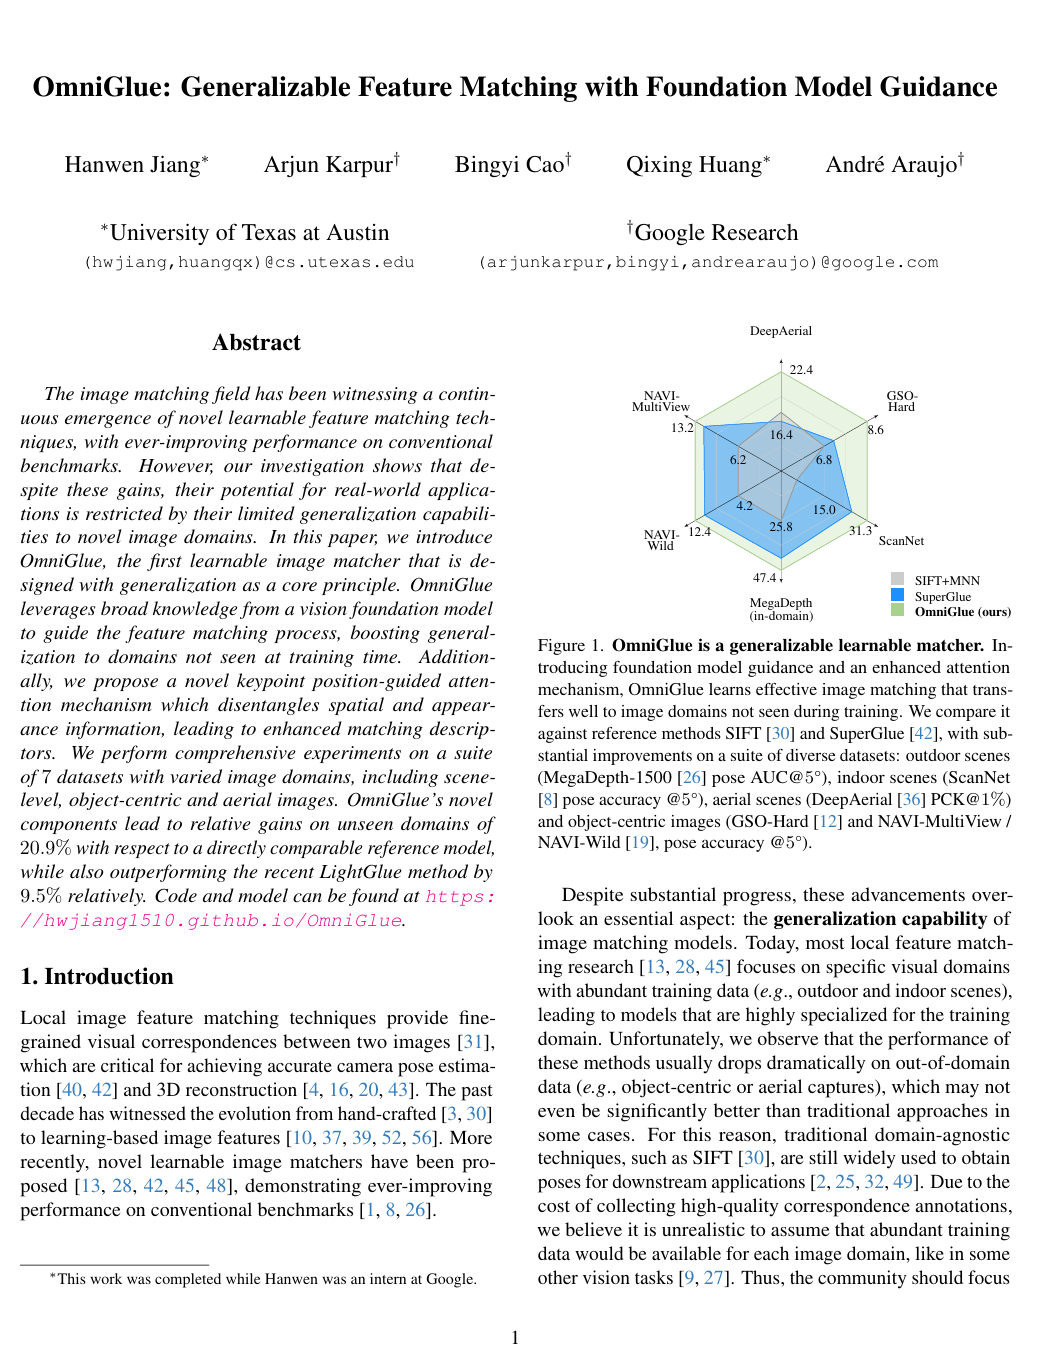

In [2]:
#!pip install docling==0.1.10
from pathlib import Path
from docling.datamodel.base_models import InputFormat
from docling_core.types.doc import ImageRefMode

from docling.datamodel.pipeline_options import (
    VlmPipelineOptions,
    smoldocling_vlm_conversion_options,
)
from docling.document_converter import DocumentConverter, ImageFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline
from PIL import Image
import base64
from io import BytesIO
import onnxruntime

# Image(s) to process
sources = [
    "/content/latex.png",  # Replace with your actual image path
]

# Configure the pipeline
pipeline_options = VlmPipelineOptions()
pipeline_options.force_backend_text = False
pipeline_options.vlm_options = smoldocling_vlm_conversion_options

# Check if CUDA is available
if onnxruntime.get_device() == 'GPU':
    pipeline_options.accelerator_options.device = "cuda"
    # check for Flash attention 2
    try:
        import torch
        if torch.cuda.get_device_capability(0)[0] >= 8:
          pipeline_options.accelerator_options.cuda_use_flash_attention2 = True
        else:
          pipeline_options.accelerator_options.cuda_use_flash_attention2 = False
    except:
        pipeline_options.accelerator_options.cuda_use_flash_attention2 = False
else:
    pipeline_options.accelerator_options.device = "cpu"
    pipeline_options.accelerator_options.cuda_use_flash_attention2 = False

doc_converter = DocumentConverter(
    format_options={
        InputFormat.IMAGE: ImageFormatOption(
            pipeline_cls=VlmPipeline,
            pipeline_options=pipeline_options,
        )
    }
)

for file_path in sources:
    image_path = Path(file_path)
    result = doc_converter.convert(image_path)

    # Export Markdown with embedded image refs
    markdown = result.document.export_to_markdown(image_mode=ImageRefMode.EMBEDDED)

    # If no image was embedded by Docling, embed the full input image manually
    if "data:image" not in markdown:
        with Image.open(image_path) as img:
            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
            markdown += f"\n\n![Full Image](data:image/png;base64,{img_base64})"

    print("\n=== Markdown with Image, Text, and Table Structure ===\n")
    print(markdown)

https://huggingface.co/ds4sd/SmolDocling-256M-preview/discussions/28